In [4]:
from __future__ import print_function
from numpy import nan_to_num, array, empty_like, empty, vstack, concatenate, linspace, tile
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt
import pickle
import gzip

In [5]:
%matplotlib inline

## Classifying extended SSVEP covariance matrices for EEG-based BCI

The first step is to load the covariance matrices obtained from the first notebook.

In [7]:
with gzip.open('../data/record-[2014.03.10-19.47.49].pz', 'rb') as f:
    o = pickle.load(f)
cov_train = o['cov_train']
cov_test = o['cov_test']
y_train = o['y_train']
y_test = o['y_test']
classes = o['classes']

UnicodeDecodeError: 'ascii' codec can't decode byte 0xb5 in position 0: ordinal not in range(128)

Covariance matrices are in separated in training and testing set, with `y` the associated labels.

## Computing mean covariance for each class

To estimate the mean covariance, this notebook relies on the implementation of [pyRiemann toolbox](https://github.com/alexandrebarachant/pyRiemann). The function mean_riemann takes a numpy ndarray of shape (n_sample, n_dim, n_dim), where n_sample is the number of covariance matrices used to compute the mean and n_dim is the size of the covariance matrices. 

In [5]:
from pyriemann.utils.mean import mean_riemann

The mean of each class is computed with:

In [6]:
cov_centers = empty((len(classes), 24, 24))
for i, l in enumerate(classes):
    cov_centers[i, :, :] = mean_riemann(cov_train[y_train == l, :, :])

## Plotting mean covariance matrices

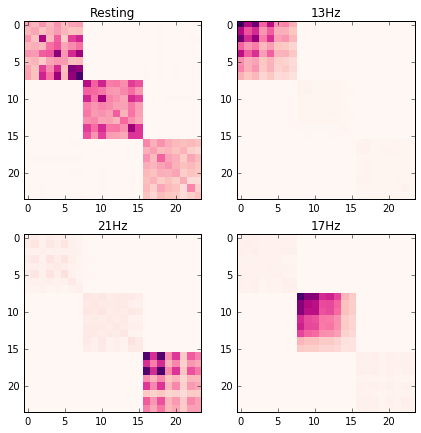

In [7]:
plt.figure(figsize=(7, 7))
for i, l in enumerate(classes):
    plt.subplot(2, 2, i+1)
    plt.imshow(cov_centers[i, :, :], cmap=plt.get_cmap('RdPu'), interpolation='nearest')
    _ = plt.title(l)

As seen in the previous notebook, the mean covariance matrices for each class concentrate the highest values in the block corresponding to the filtered signal in the associated bandwith. The resting signal shows high correlations split across all frequencies.

## Minimum distance to mean

The classification scheme is simple, each test sample $\hat{\Sigma}$ is associated to the class with the smallest distance to mean $\Sigma^{c}_{\mu}$ :
\begin{equation}
c^{*} = \mathrm{argmin}_{c} \delta(\hat{\Sigma}, \Sigma^{c}_{\mu})
\end{equation}
The Riemannian distance used here is the AIRM, implemented in pyRiemann

In [8]:
from pyriemann.utils.distance import distance_riemann

In [9]:
accuracy = list()
for sample, true_label in zip(cov_test, y_test):
    dist = [distance_riemann(sample, cov_centers[m]) for m in range(len(classes))]
    if classes[array(dist).argmin()] == true_label:
        accuracy.append(1)
    else: accuracy.append(0)
test_accuracy = 100.*array(accuracy).sum()/len(y_test)
            
print ('Evaluation accuracy on test set is %.2f%%' % test_accuracy)

Evaluation accuracy on test set is 91.67%
